In [3]:
X = pd.read_csv("train_x.csv", header = None)

In [69]:
import pandas as pd
import numpy as np
import cv2
import heapq
import matplotlib.pyplot as plt

class characterExtractor:

    WHITE = 255

    SOFT_THRESH = 205
    HARD_THRESH = 254

    MAX_WHITE_PX_THRESH = 730

    MAX_CONTOURS_THRESH = 10

    CHAR_PERIMETER_THRESH = 15
    CHAR_AREA_THRESH = 19

    def __init__(self, data_csv=None, pd_data=None):
        """ Expecting train_x or test_x csv file """

        if len(pd_data.index):
            self.data = pd_data
        else:
            self.data = pd.read_csv(data_csv, header = None)

    def extractCharacters(self, x_serie):
        """ Extract all characters from img """
        global img_og
        img_og = x_serie.values.reshape(64,64).astype(np.uint8)
        img = img_og.copy()

        #apply first soft threshold
        _ , img = cv2.threshold(img, self.SOFT_THRESH, self.WHITE, cv2.THRESH_BINARY)


        #apply second hard threshold for bright patterns 
        img_white_px = len(img[img > self.SOFT_THRESH])
        if img_white_px > self.MAX_WHITE_PX_THRESH:
            _ , img = cv2.threshold(img, self.HARD_THRESH, self.WHITE, cv2.THRESH_BINARY)

        #apply median blur for the rice patterns
        _ , contours , _ = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > self.MAX_CONTOURS_THRESH: 
            img = cv2.medianBlur(img, 3)
            _ , contours , _ = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

        #extract potential character contours
        c = self.findPotentialContours(contours)
        (img_c1, img_c2, img_c3) = self.processPotentialContours(c, img)
        
        return (img_c1, img_c2, img_c3)
        #should just return the images
        #instead of plotting
        
    def findPotentialContours(self, contours):
        c = []
        for cnt in contours:
            perimeter = cv2.arcLength(cnt, True)
            area = cv2.contourArea(cnt)
            if perimeter > self.CHAR_PERIMETER_THRESH and area > self.CHAR_AREA_THRESH:
                heapq.heappush(c, (-perimeter, -area, cnt))
                
        return c

    def processPotentialContours(self, c, img, d=None):
        num_chars = len(c)
        
        if num_chars > 3:
            print(">3")
            #restart image processing with another approach
            if not d:
                d = 2
            img = img_og.copy()
            img = cv2.dilate(img,np.ones((d,d),np.uint8),iterations=1)
            _, img = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
            _ , contours , _ = cv2.findContours(img, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            
            new_c = self.findPotentialContours(contours)
            return self.processPotentialContours(new_c,img,d=d+1)
            
        elif num_chars == 2:
            print("CUT MIDDLE")
            img_c1,img_c2,img_c3 = self.getCharactersAfterMiddleCut(c, img)
            return (img_c1,img_c2,img_c3)
        elif num_chars < 2:
            print("<2")
        else:
            print("PERFECT")
#             print(c)
            cnt1 = heapq.heappop(c)[2]
            cnt2 = heapq.heappop(c)[2]
            cnt3 = heapq.heappop(c)[2]
            
            c1 = cv2.boundingRect( cnt1 )
            c2 = cv2.boundingRect( cnt2 )
            c3 = cv2.boundingRect( cnt3 )
            
            img_c1 = self.getImgFromContour(c1, img)
            img_c2 = self.getImgFromContour(c2, img)
            img_c3 = self.getImgFromContour(c3, img)
            
            return (img_c1, img_c2, img_c3)
            
    def getCharactersAfterMiddleCut(self, c, img):
        biggest_contour = heapq.heappop(c)[1]
        x,y,w,h = cv2.boundingRect(biggest_contour)
        
        if w > h: # width bigger than height, cut in middle of width
            m = w//2
            c1 = (x  , y, m, h)
            c2 = (x+m, y, m, h)
        else:
            m = h//2
            c1 = (x, y  , w, m)
            c2 = (x, y+m, w, m)
        
        #in case characters are in diagonal of each other
        img_c1 = self.getImgFromContour(c1,img)
        img_c2 = self.getImgFromContour(c2,img)
        
        _ , contours_c1 , _ = cv2.findContours(img_c1, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        print("c1",len(contours_c1))
        _ , contours_c2 , _ = cv2.findContours(img_c2, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        print("c2",len(contours_c2))
        
        c1 = cv2.boundingRect( max(contours_c1, key = cv2.contourArea) )
        c2 = cv2.boundingRect( max(contours_c2, key = cv2.contourArea) )
        c3 = cv2.boundingRect( heapq.heappop(c)[1] )
        
        #print(c1,c2,c3)
        
        img_c1 = self.getImgFromContour(c1,img_c1)
        img_c2 = self.getImgFromContour(c2,img_c2)
        img_c3 = self.getImgFromContour(c3,img)
               
        return (img_c1,img_c2,img_c3)
    
    def getImgFromContour(self, cnt_bound, img_copy):
        x,y,w,h = cnt_bound
        print(x,y,w,h)
        return img_copy[y:y+h, x:x+w]

    def extractCharactersFrom(self, choice):
        x_serie = self.data.iloc[choice]
        self.extractCharacters(x_serie)

    def extractCharactersFromAndPlot(self, choice):
        x_serie = self.data.iloc[choice]
        char_imgs = self.extractCharacters(x_serie)
        
        plt.figure(figsize=(5,5))
        m_size = (1,3)
        for i,img in enumerate(char_imgs):
            plt.subplot(1, 3, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(""), plt.xticks([]), plt.yticks([])
            #self.plot_img(img, "",(i+1))
        plt.show()

    def plot_img(img, title, size, pos):
        plt.subplot(size[0], size[1], pos), plt.imshow(img, cmap="gray")
        plt.title(title), plt.xticks([]), plt.yticks([])


In [70]:
ce = characterExtractor(pd_data=X)

In [71]:
ce.extractCharactersFrom(11674)

>3
>3
PERFECT
37 20 23 25
3 38 24 19
9 8 16 22


>3
PERFECT
34 23 19 25
3 11 29 14
9 44 23 16


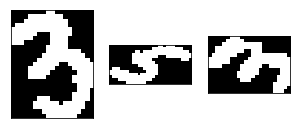

In [76]:
ce.extractCharactersFromAndPlot(13143)